<a href="https://colab.research.google.com/github/danon6868/blastim-ml/blob/main/ml_lm_dt_day_11/DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

from sklearn import tree
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap

## Деревья решений

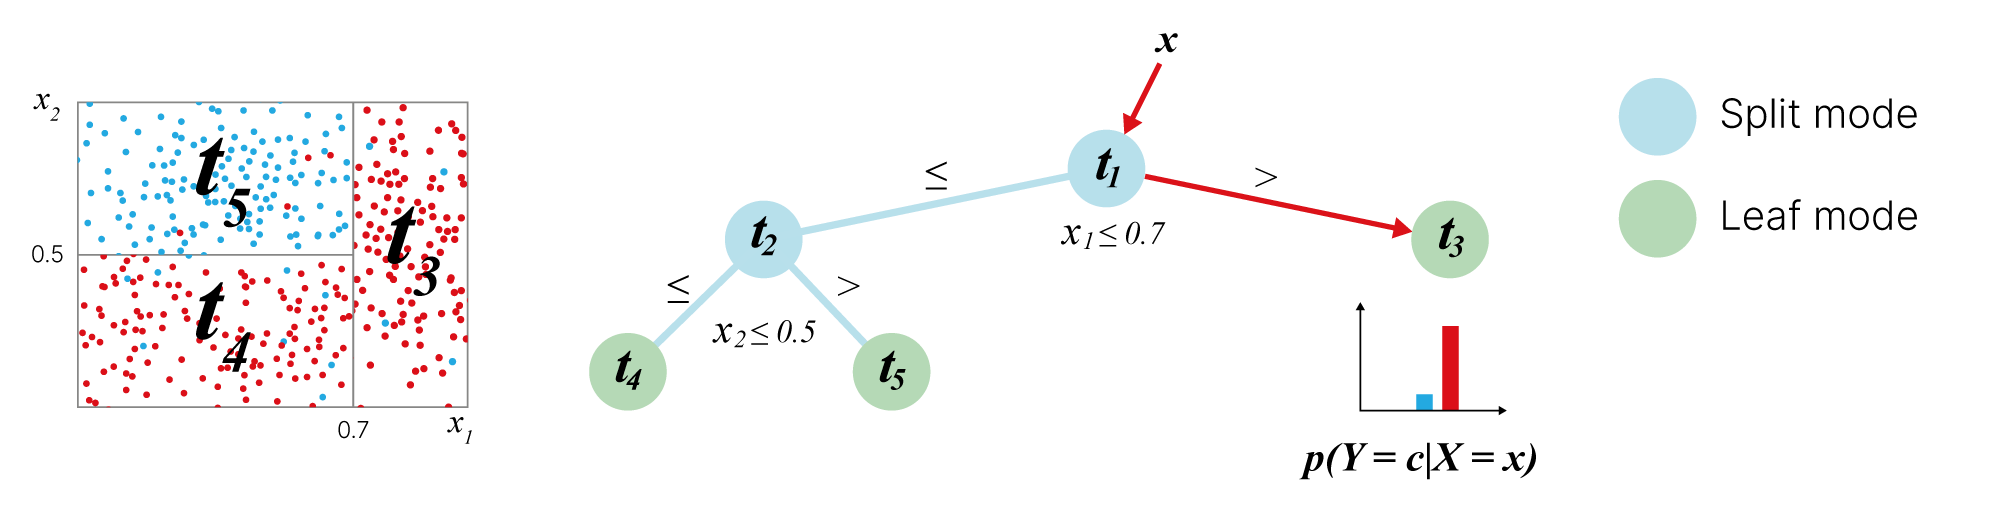

Выбираем самое "хорошее" разбиение, исходя из какой-то метрики. Одна из основных называется $Gini$:

$$Gini = 1 - \sum_ip_i^2$$

Фактически, она показывает, какова вероятность того, что два объекта, попавшие в один узел, принадлежат разным классам. Соответственно, чем она ниже, тем лучше получившийся узел.

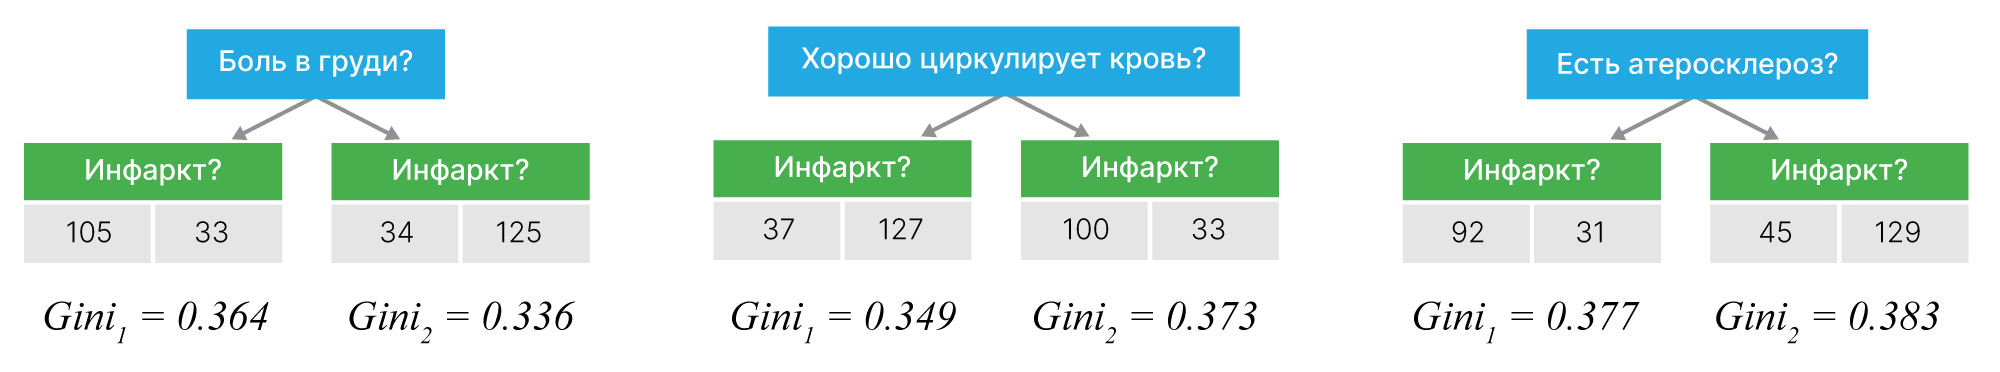

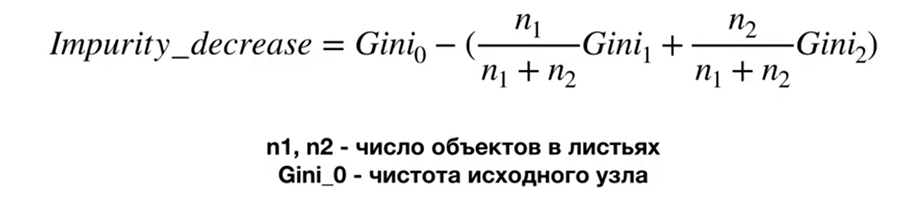

Исходно имеем:

* 139 человек с инфарктом
* 158 здоровых
* Всего 297

Посчитаем изначальное значение $Gini_0$:

In [2]:
p0 = 139 / 297
p1 = 158 / 297
gini_0 = 1 - np.sum(np.power([p0, p1], 2))
print(f"Gini_0 is: {gini_0:.3f}")

Gini_0 is: 0.498


Impurity decrease для первого сплита:

In [3]:
imp_dec_1 = gini_0 - (138 / 297 * 0.364 + 159 / 297 * 0.336)
print(f"Impurity decrease for 1st feature: {imp_dec_1:.3f}")

Impurity decrease for 1st feature: 0.149


Impurity decrease для второго сплита:

In [4]:
imp_dec_2 = gini_0 - (164 / 297 * 0.349 + 133 / 297 * 0.373)
print(f"Impurity decrease for 2nd feature: {imp_dec_2:.3f}")

Impurity decrease for 2nd feature: 0.138


Impurity decrease для третьего сплита:

In [5]:
imp_dec_3 = gini_0 - (123 / 297 * 0.377 + 174 / 297 * 0.383)
print(f"Impurity decrease for 3rd feature: {imp_dec_3:.3f}")

Impurity decrease for 3rd feature: 0.117


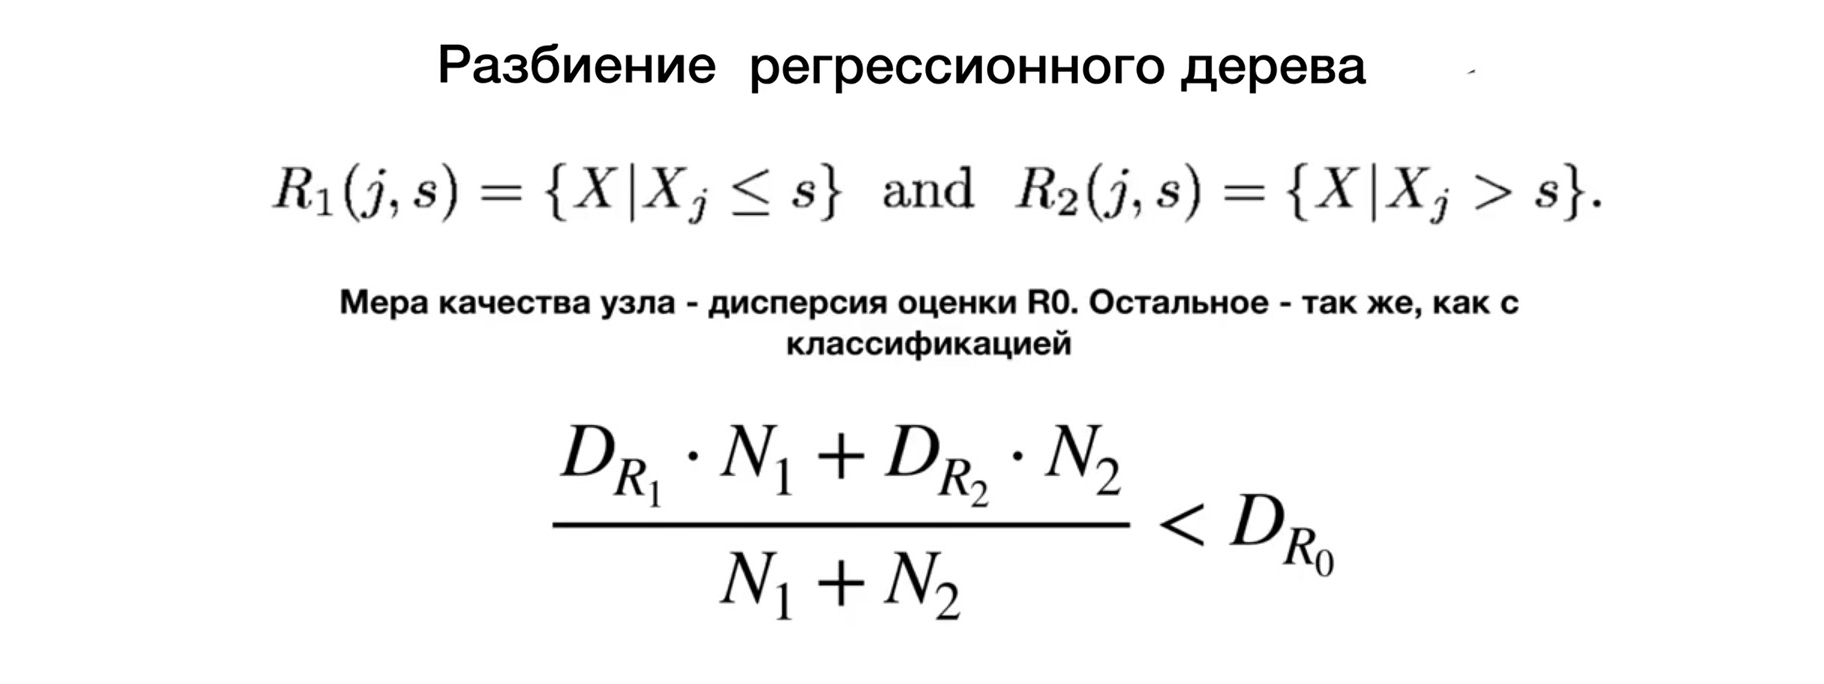

## Неустойчивость деревьев решений

In [6]:
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Сделаем классифиацию бинарной
df["target"] = data.target != 1 # 0 for setosa, 1 - versicolor, 2 - virginica

Сделаем два разных разбиения на обучение и тест. И посмотрим, будут ли отличаться деревья, построенные для данных разбиений.

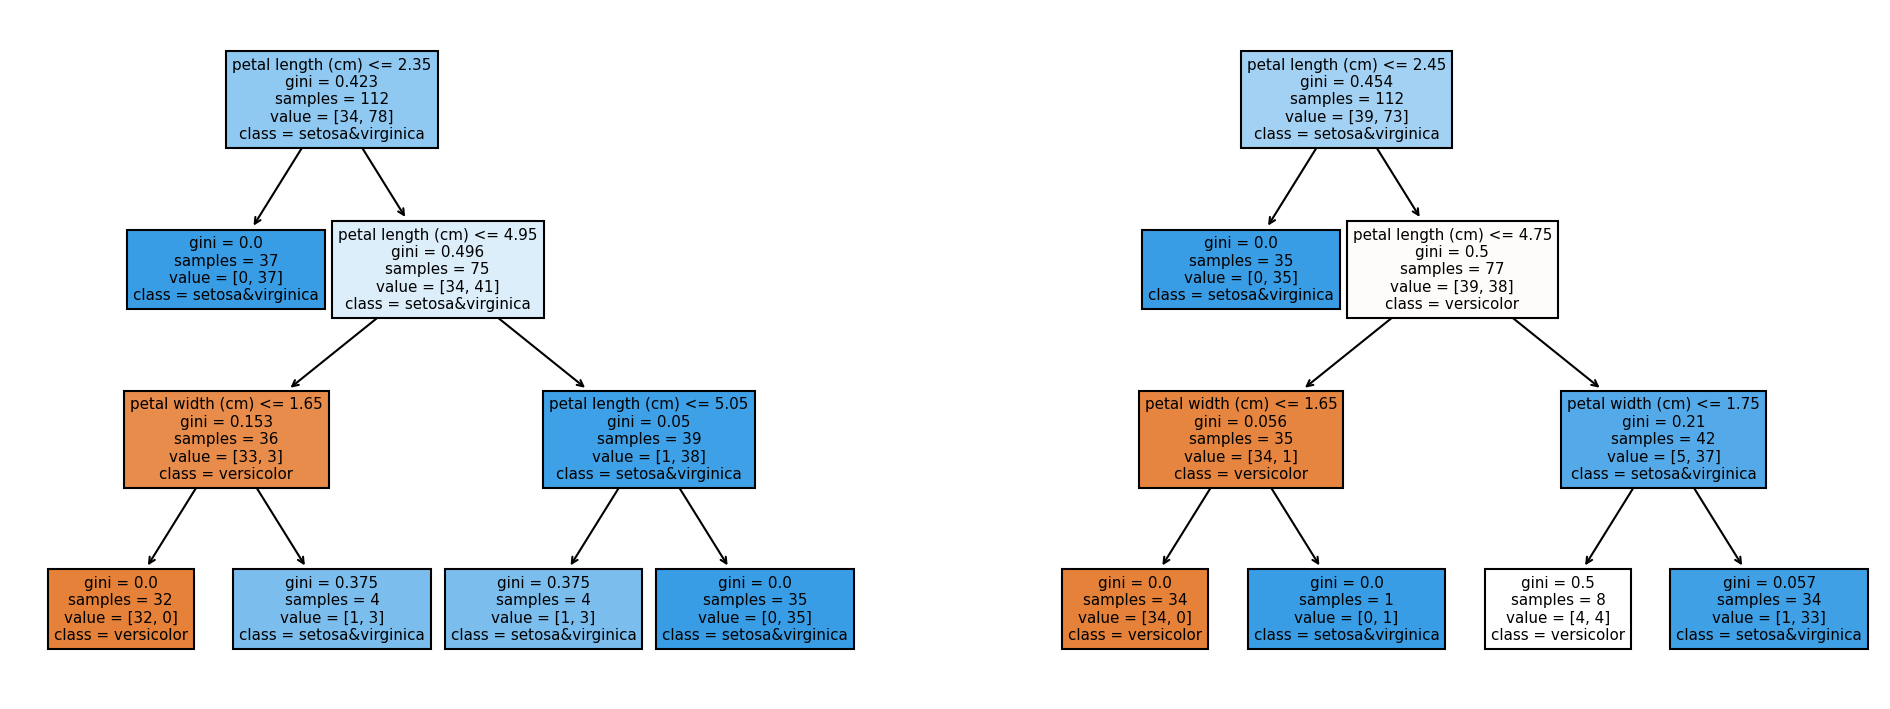

In [7]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[data.feature_names], df["target"],
                                                        random_state=0)
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[data.feature_names], df["target"],
                                                        random_state=42)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X_train2, y_train2)


fn = ["sepal length (cm)", "sepal width (cm)",
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 6), dpi=150)
tree.plot_tree(clf1,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[0])

tree.plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

А если взять деревья поглубже:

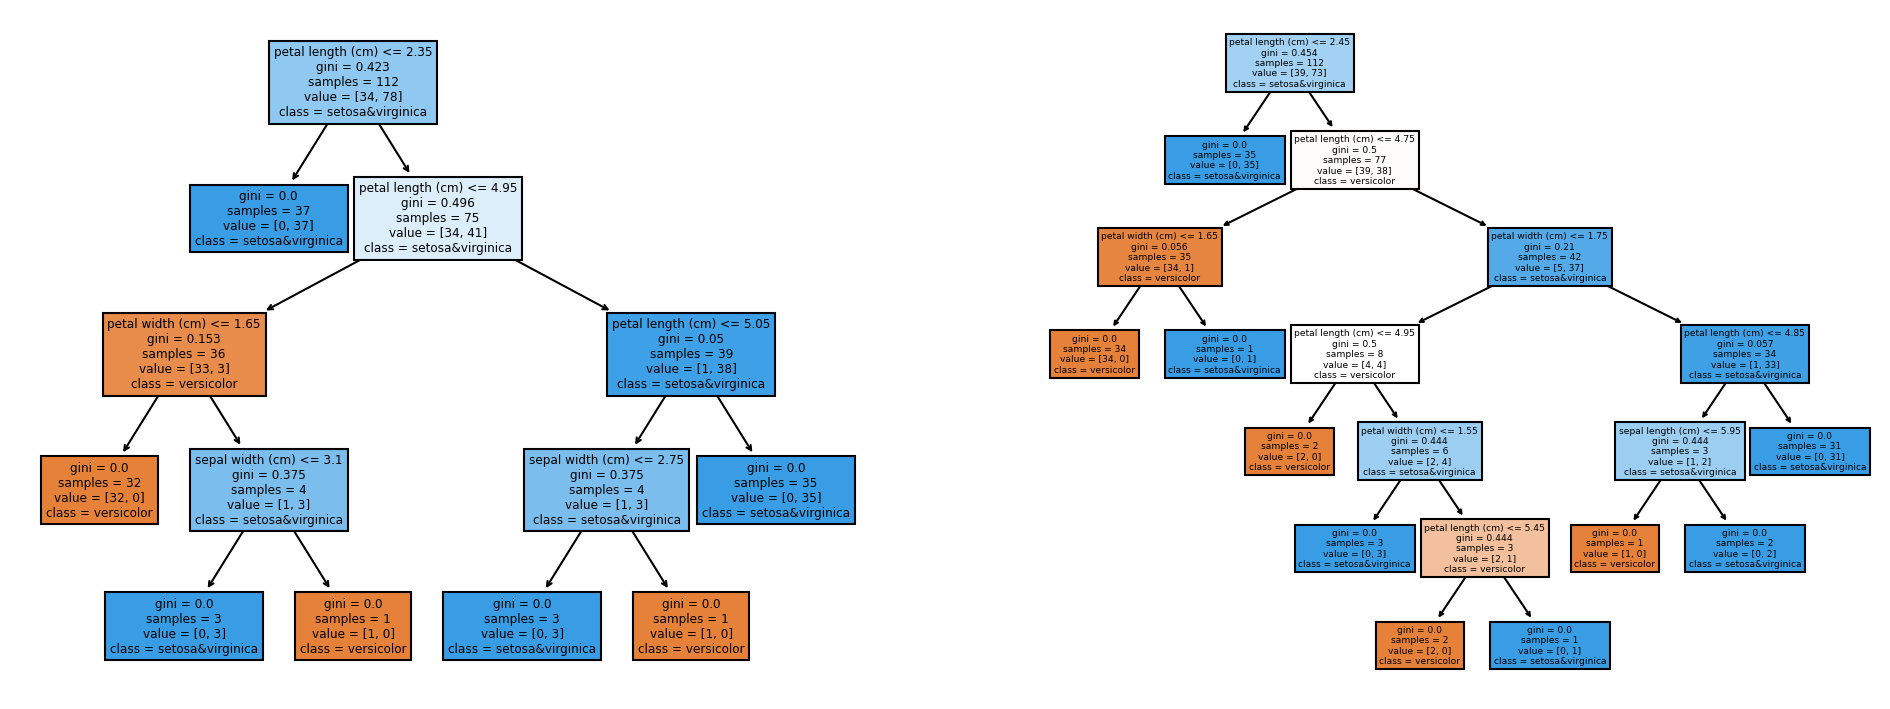

In [8]:
# первый набор точек
clf1 = DecisionTreeClassifier(max_depth=10)
clf1.fit(X_train1, y_train1)

# второй набор точек
clf2 = DecisionTreeClassifier(max_depth=10)
clf2.fit(X_train2, y_train2)


fn = ["sepal length (cm)", "sepal width (cm)",
      "petal length (cm)", "petal width (cm)"]

cn = ["versicolor", "setosa&virginica"]

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 6), dpi=150)
tree.plot_tree(clf1,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[0])

tree.plot_tree(clf2,
               feature_names=fn,
               class_names=cn,
               filled=True, ax=axes[1])
plt.show()

## Переобучение деревьев

Если алгоритм при небольшом изменении признаков сильно меняет свое решение, это, как правило, указывает на переобучение. Алгоритм сильно реагируют на любой шум в данных - доверять его решениям не стоит.

Будем использовать исскуственные данные и нереальный рисунок карандашом для визуализации разделяющих поверхностей.

In [9]:
#handson-ml
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

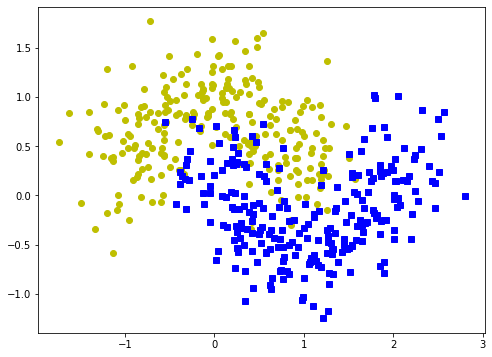

In [10]:
X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

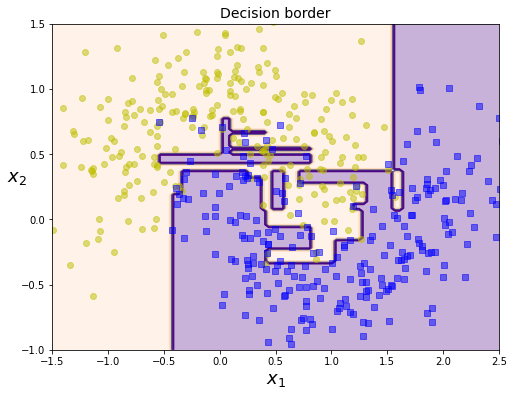

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

#### Разделяющая поверхность в зависимости от обучающих данных:

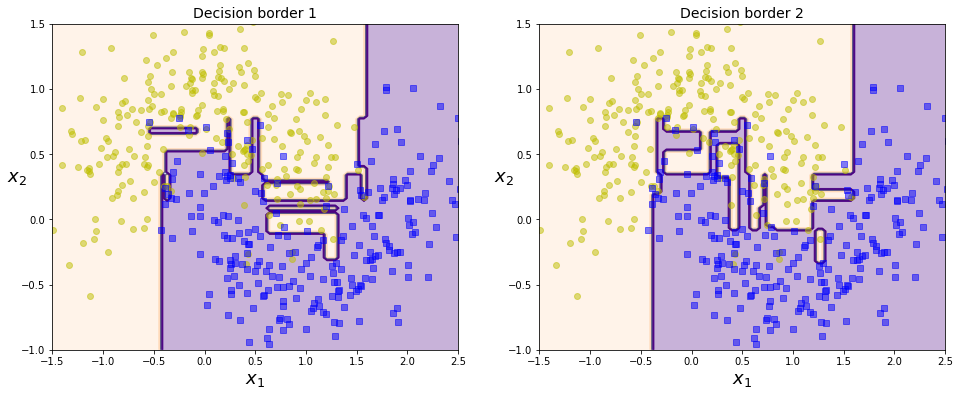

In [12]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

Границы решений поменялись, причем сильно. Исчезли одни "рваные" границы и появились другие. Опять же, наше дерево неустойчиво, из-за малейшего шума в данных оно может поменять свое предсказания. Оно переобучается на шум в данных.

Говорят, что у нашего дерева высокий **variance**.

Можно ли что-то поправить? Ну, у нас в настройках максимальная глубина дерева поставлена равной 20. Это очевидно много. Давайте сделаем дерево глубины 1:

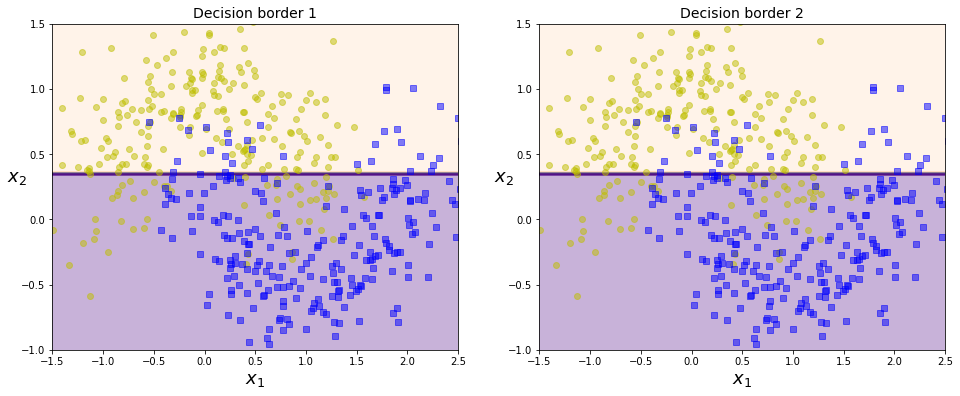

In [13]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=1, random_state=42)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=1, random_state=42)
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

А теперь глубины 2:

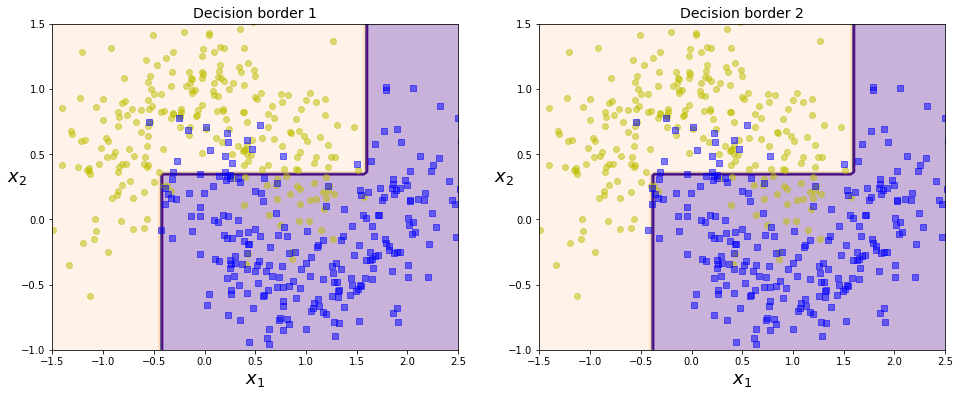

In [14]:
# первый набор точек
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
clf1 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf1.fit(X_train1, y_train1)

# второй набор точек
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=2)
clf2 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf2.fit(X_train2, y_train2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X, y)
plt.title("Decision border 1", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X, y)
plt.title("Decision border 2", fontsize=14)
plt.show()

Сравним разную глубину на одинаковых данных:

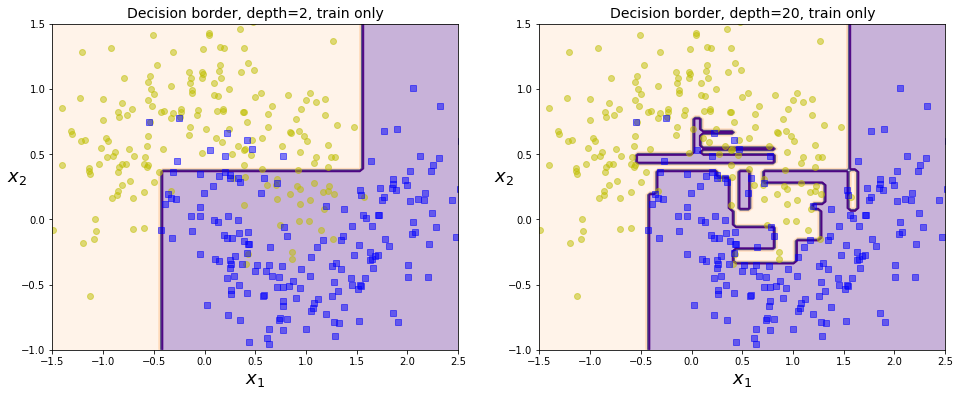

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf1.fit(X_train, y_train)

clf2 = DecisionTreeClassifier(max_depth=20, random_state=42)
clf2.fit(X_train, y_train)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plot_decision_boundary(clf1, X_train, y_train)
plt.title("Decision border, depth=2, train only", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X_train, y_train)
plt.title("Decision border, depth=20, train only", fontsize=14)
plt.show()